# LAB 7

This Lab introduces the Reaction term into the Advection-Diffusion-Reaction problems

In [ ]:
# Installation of firedrake
try:
  import firedrake
except ImportError:
  !wget "https://fem-on-colab.github.io/releases/firedrake-install-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
  import firedrak

## EXERCISE 1:

Let us consider the diffusion-reaction problem
$$
\begin{cases}
- \nabla \cdot (\mu \nabla u) + \sigma u = f & \text{in $\Omega = (0,1)\times(0,1)$} \\
u = 0 & \text{on $x=0 \cup y=0$} \\
u = 1 & \text{on $x=1 \cup y=1$}
\end{cases}
$$
with $\mu = 10^{-4}$, $\sigma = 1$, $f = 0$. \\

(a) Write the weak formulation of the problem. \\
(b) Estimate the mesh size needed to obtain a reactive Péclet number $Pe < 1$. \\
(c) Solve the problem in Firedrake using the mass-lumping technique (see https://www.firedrakeproject.org/demos/igher_order_mass_lumping.py.html for a reference).


### (a) Write the weak formulation of the problem.

The weak form of the above problem is: \\

$$
\int_{\Omega} (-μ \Delta u + σu)v \, dx
$$

Now integrating by parts the first term of the integral: \\
$$
-μ \int_{\Omega} \Delta u v \, dx = -μ (\int_{\partial\Omega} \boldsymbol{∇}u \cdot \boldsymbol{n} v \, ds - \int_{\Omega} \boldsymbol{∇} u \cdot \boldsymbol{∇}v \, dx)
$$

Now, the boundary $\partial Ω$ can be divided into Newmann and Diriclet. Since this time we only have Diriclet, then the weak firmulation becomes: \\

$$
\text{Find } u\in \{ v \in H^1(\Omega) \, : \, v|_{ \partial \Omega} = g_D\} \;\text{ such that } \; a(u, v) = L(v) \quad \forall v\in H^1_0(\Omega),
$$ \\

where the bilinear form is \\

\begin{equation*}
  a(u, v) = \int_0^1 \left( \mu \boldsymbol{\nabla} u\cdot \boldsymbol{\nabla} v + \sigma u v \right)\, d\boldsymbol{x},
\end{equation*} \\

and the linear functional \\

\begin{equation*}
  L(v) = \int_\Omega f v \, d\boldsymbol{x}.
\end{equation*} \\

\\

\\

NOTE: here we've two different Diriclèt B.C.s (check in the problem how to set them using Firedrake)

### (b) Estimate the mesh size needed to obtain a reactive Péclet number $Pe < 1$.

The reactive Péclet number is defined as: \\

$$
Pe = \frac{\sigma h^2}{6 \mu}.
$$ \\

Now, to have a stable problem which means have a $Pe < 1$ we need a mesh size: \\

$$
h < \sqrt{\frac{6\mu}{σ}}
$$

### (c) Solve the problem in Firedrake using the mass-lumping technique

In [ ]:
from firedrake import *
import finat

import matplotlib.pyplot as plt
import firedrake.pyplot as fdplt
import numpy as np

In [ ]:
# Define the Mesh:
N = 10
mesh = UnitSquareMesh(N, N)
V = FunctionSpace(mesh, 'P', 1)

# # Plot the mesh:
# fig, ax = plt.subplots()
# fdplt.triplot(mesh, axes=ax)
# ax.legend()

This mesh il not good to have an accurate solution, in fact th Peclet nuber is:

In [ ]:
h = CellDiameter(mesh)
Pe = sigma*h**2/(6*mu) # Pointwise value
meanPe = assemble(Pe*dx)
print('Mean Peclet number = ', meanPe)

Mean Peclet number =  33.33333333333333


Let's first see that the solution in this way is NOT good

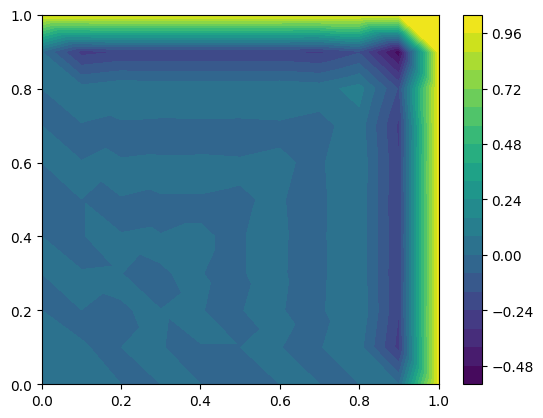

In [ ]:
# Set data:
mu = Constant(1e-4)
sigma = Constant(1.)
f = Constant(0.)


# Boundary conditions:
bc0 = DirichletBC(V, Constant(0.), (1, 3))
bc1 = DirichletBC(V, Constant(1.), (2, 4))


# Define the weak formulation:
u = TrialFunction(V)
v = TestFunction(V)

a = mu*dot(grad(u), grad(v)) * dx + sigma * u * v * dx
L = f * v * dx

# Solve the problem:
u_h = Function(V)
solve(a==L, u_h, bcs=(bc0, bc1))


# Plot the results:
fig, ax = plt.subplots()
q = fdplt.tricontourf(u_h, axes=ax, levels=20)
plt.colorbar(q)

We notice that we're getting some negative values and it is not correct because the solution should be all positive, so let's fix this. \\
We also have oscillations!! \\

Therefore we wnat to implement the LUMPING-MASS MATRIX method to get a more accurate solution. \\

In [ ]:
# Assemble of the Mass matrix:
M = assemble(u*v*dx).M.values

Now to built the Lumped mass matrix remember from the theory that there are two methods: \\
*  Summing-up the rows of the mass matrix and place the value on the main diagonal
*  Implementing a quadrature formula


Let's see those two different techniques:

In [ ]:
# By hand, summing over the rows
# M_lump_diag = np.sum(M.M.values, axis=1) ?????????


# With a suitable choice of quadrature rule
quad_rule = finat.quadrature.make_quadrature(V.finat_element.cell, 1, "KMV")
dxlump=dx(scheme=quad_rule) # Lumped integration rule

m_lump = u*v*dxlump

So, now let's use the quadrature formula and in particular **dxlump** insead of dx to solve our problem:

/usr/local/lib/python3.10/dist-packages/ufl/utils/sorting.py:84: UserWarning: Applying str() to a metadata value of type QuadratureRule, don't know if this is safe.
  warnings.warn(f"Applying str() to a metadata value of type {type(value).__name__}, "


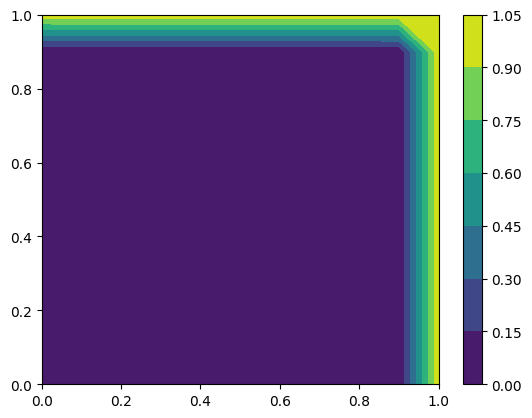

In [ ]:
# Set data:
mu = Constant(1e-4)
sigma = Constant(1.)
f = Constant(0.)


# Boundary conditions:
bc0 = DirichletBC(V, Constant(0.), (1, 3))
bc1 = DirichletBC(V, Constant(1.), (2, 4))


# Define the weak formulation:
u = TrialFunction(V)
v = TestFunction(V)

a = mu*dot(grad(u), grad(v)) * dx + sigma * u * v * dxlump
L = f * v * dx

# Solve the problem:
u_h = Function(V)
solve(a==L, u_h, bcs=(bc0, bc1))

# Plot the results:
fug, ax = plt.subplots()
q = fdplt.tricontourf(u_h, axes=ax)
plt.colorbar(q)

So we notice that we've not spore oscillations because we do not have any results below zero. \\
Obviusly to have a better result we have to impose a more fine mesh.

## EXERCISE 2

Consider the PDE problem \\

$$
\begin{cases}
-∆u + 2u = f \quad \quad \text{in} \, \, Ω = (0, 1)^2 \\
u = 0 \quad \quad \quad \quad \quad \text{on} \, ∂Ω
\end{cases}
$$ \\

(a) Write the weak formulation of the problem. \\
(b) Study the well posedness (existence and uniqueness of a solution) of the (weak) problem. \\
(c) Consider the exact solution $u(x, y) = sin(πx) sin(πy)$. Compute the corresponding right-hand side $f$. \\
(d) Solve the problem using Firedrake and plot the solution. \\
(e) What is the expected convergence rate in the $H^1$ norm? Verify it numerically \\

## EXERCISE 3

Consider the advection-diffusion-reaction problem \\

$$
\begin{cases}
−∆u + \boldsymbol{∇} · (\boldsymbol{b}u) + u = 0 \quad \quad \text{in} \, \, Ω = (0, 1)^2 \\
u = \phi \ quad \quad \quad \quad \quad \text{on} \, ∂Ω
\end{cases}
$$ \\

where $\boldsymbol{b} = [1000, 1000]^T$ and: \\

$$
\phi = \begin{cases}
1 \quad \text{for } \, \, x = 0, \, \text{and } \, 0 < y < 1 \\
1 \quad \text{for } \, \, y = 0, \, \text{and } \, 0 < x < 1 \\
0 \quad \text{elsewhere }
\end{cases}
$$ \\

(a) Is it possible to give an estimate about the maximum value of cell diameter h that can be used when solving the problem with the classical Galerkin scheme? \\
(b) Write the weak formulation of the problem. \\
(c) Solve the problem by implementing the SUPG method in Firedrake.